In [23]:
import glob
import os
import errno
import matplotlib.pyplot as plt
from deepcell_spots.data_utils import get_data
from deepcell_spots.postprocessing_utils import *

In [2]:
data_dir = '/data/example_data/'
npz_dir = glob.glob(data_dir +'*em*.npz')[0]
npz_dir

'/data/example_data/em_output.npz'

In [3]:
seed = 0
test_size=0.1 # % of data saved as test
train_dict, test_dict = get_data(npz_dir, test_size=test_size, seed=seed, allow_pickle=True)
X_train, y_train = train_dict['X'], train_dict['y']
X_test, y_test = test_dict['X'], test_dict['y']

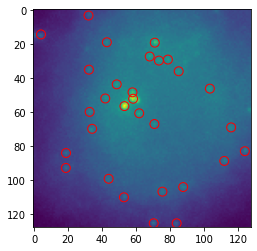

In [4]:
# visualize to check that it loaded correctly
ind=100
plt.imshow(X_train[ind])
plt.scatter(y_train[ind][:,1], y_train[ind][:,0], edgecolors='r', facecolors='None', s=80)
plt.show()

In [7]:
# Set up required filepaths

modeldir = data_dir + 'models'
logdir = data_dir + 'logs'

# create directories if they do not exist
for d in (modeldir, logdir):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise
            
print('model dir: ', modeldir)
print('log dir: ', logdir)

model dir:  /data/example_data/models
log dir:  /data/example_data/logs


In [8]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

conv_model_name = 'conv_dots_model_em_w_suntag'

n_epoch = 10  # Number of training epochs
norm_method = None  # data normalization - options are: 'std','max', None, 'whole_image'
receptive_field = 13  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

In [9]:
from deepcell_spots.dotnet import dot_net_2D

dots_model = dot_net_2D(receptive_field=receptive_field,
               input_shape=tuple(X_train.shape[1:]),
               inputs=None,
               n_skips=n_skips,
               norm_method=norm_method,
               padding_mode='reflect')

In [10]:
dots_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
model_4 (Functional)            (None, 128, 128, 128 501504      input_1[0][0]                    
__________________________________________________________________________________________________
offset_regression_head (Functio (None, 128, 128, 2)  2070018     model_4[0][0]                    
__________________________________________________________________________________________________
classification_head (Functional (None, 128, 128, 2)  17282       model_4[0][0]                    
____________________________________________________________________________________________

In [12]:
from deepcell_spots.training import train_model_dot

train_model_dot(model=dots_model,
                dataset=npz_dir,
                test_size=test_size,
                seed=seed,
                n_epoch=n_epoch,
                batch_size=batch_size,
                optimizer=optimizer,
                log_dir=logdir,
                model_dir=modeldir,
                model_name=conv_model_name,
                focal=True,
                lr_sched=lr_sched,
                rotation_range=180,
                flip=True,
                shear=False,
                zoom_range=(0.8, 1.2),
                fill_mode='reflect'
                )

X_train shape: (552, 128, 128, 1)
y_train shape: (552,)
X_test shape: (62, 128, 128, 1)
y_test shape: (62,)
Output Shape: (None, 128, 128, 2)
Number of Classes: 2
Training on 1 GPUs


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
552/552 [==============================] - 162s 284ms/step - loss: 1.3547 - offset_regression_loss: 1.2337 - classification_loss: 0.1023 - offset_regression_accuracy: 0.5361 - classification_accuracy: 0.9424 - val_loss: 0.5203 - val_offset_regression_loss: 0.4597 - val_classification_loss: 0.0418 - val_offset_regression_accuracy: 0.5087 - val_classification_accuracy: 0.9854

Epoch 00001: val_loss improved from inf to 0.52032, saving model to /data/example_data/models/conv_dots_model_em_w_suntag.h5
Epoch 2/10
552/552 [==============================] - 155s 281ms/step - loss: 0.5325 - offset_regression_loss: 0.4796 - classification_loss: 0.0340 - offset_regression_accuracy: 0.5008 - classification_accuracy: 0.9801 - val_loss: 0.4563 - val_offset_regression_loss: 0.4047 - val_classification_loss: 0.0327 - val_offset_regression_accuracy: 0.5226 - val_classification_accuracy: 0.9736

Epoch 00002: val_loss improved from 0.52032 to 0.45626, saving model to /data/example_data/models

In [15]:
y_pred_test = dots_model.predict(X_test)
print(len(X_test))
print('test image result shape:', y_pred_test[0].shape)

62
test image result shape: (62, 128, 128, 2)


Text(0.5, 1.0, 'Classification prediction')

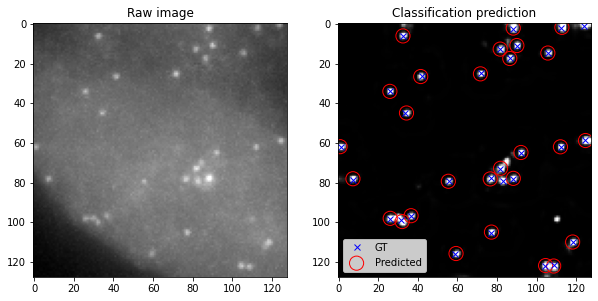

In [26]:
ind = 1
vmax=0.9
# plots results with restrictive decision
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(X_test[ind,...,0],vmax=vmax,cmap='gray')
ax[0].set_title('Raw image')

# mark above threshold pixels (opaque plot over original)
threshold = 0.98
#above_thresh = y_pred_test[1][ind,...,1] > thresh
#plt.imshow(above_thresh, alpha=0.5)
points_list2 = y_annotations_to_point_list_max(y_pred_test, ind, threshold,min_distance=1)
# plot ground truth centers, and predictions
ax[1].imshow(y_pred_test[1][ind,:,:,1],vmax=vmax,cmap='gray')
ax[1].scatter(points_list2[:,1], points_list2[:,0],edgecolors='r', facecolors='None',s=200,label='Predicted')
ax[1].plot(y_test[ind][:,1],y_test[ind][:,0],'xb',label='GT')
ax[1].legend()
ax[1].set_title('Classification prediction')